In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_directory =  '/home/mrpk9/Academic/Spring 2024/Data Mining/BraTS Dataset/BraTS Classification'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64 #increasing is not helping, so curse of dimensionality is observed
BATCH_SIZE = 1
SEED = 42
LEARNING_RATE = 0.000001
LR_DECAY = 0.9
num_epochs = 250

In [6]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    
    data = cv2.resize(data, (img_size, img_size))
    return data

def load_dicom_image_new(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if rotate > 0:
        rot_choices = [
            0,
            cv2.ROTATE_90_CLOCKWISE,
            cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180,
        ]
        data = cv2.rotate(data, rot_choices[rotate])

    data = cv2.resize(data, (img_size, img_size))
    return data

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))
    
    every_nth = len(files) / num_imgs
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)]
    
    files_to_load = [files[i] for i in indexes]
    
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T 
    
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)
    
    return np.expand_dims(img3d,0)


# load_dicom_images_3d("00000", mri_type=mri_types[0]).shape


def load_dicom_images_3d_new(case_id,num_imgs=NUM_IMAGES,img_size=SIZE,mri_type="FLAIR",split="train",rotate=0):
        # case_id = str(case_id).zfill(5)

        # path = f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"
        # files = sorted(
        #     glob.glob(path),
        #     key=lambda var: [
        #         int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
        #     ],
        # )
        files = natural_sort(glob.glob(f"{data_directory}/{split}/{case_id}/{mri_type}/*.dcm"))
        middle = len(files) // 2
        num_imgs2 = num_imgs // 2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        image_stack = [load_dicom_image_new(f, rotate=rotate) for f in files[p1:p2]]
        
        img3d = np.stack(image_stack).T
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d, n_zero), axis=-1)

        if np.min(img3d) < np.max(img3d):
            img3d = img3d - np.min(img3d)
            img3d = img3d / np.max(img3d)

        return np.expand_dims(img3d, 0)

In [7]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

In [8]:
samples_to_exclude = [109, 123, 709]

train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", train_df.shape)
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_df["MGMT_value"],
)

original shape (585, 2)
new shape (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [9]:
df_train.tail()

,BraTS21ID,MGMT_value
549,803,0
366,540,0
504,735,0
305,444,0
526,773,1


In [10]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            # data = load_dicom_images_3d_new(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
            data = load_dicom_images_3d_new(str(scan_id).zfill(5),mri_type=self.mri_type[index],split=self.split)
        else:
            # data = load_dicom_images_3d_new(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            data = load_dicom_images_3d_new(str(scan_id).zfill(5),mri_type=self.mri_type[index],split="train")
            # data = load_dicom_images_3d_new(scan_id, mri_type=self.mri_type[index], split="train")
        
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index])}

In [11]:
mri_type = 'T1w'
if mri_type=="all":
    train_list = []
    valid_list = []
    for mri_type in mri_types:
        df_train.loc[:,"MRI_Type"] = mri_type
        train_list.append(df_train.copy())
        df_valid.loc[:,"MRI_Type"] = mri_type
        valid_list.append(df_valid.copy())

    df_train = pd.concat(train_list)
    df_valid = pd.concat(valid_list)
else:
    df_train.loc[:,"MRI_Type"] = mri_type
    df_valid.loc[:,"MRI_Type"] = mri_type

#print(df_train.shape, df_valid.shape)
display(df_train.head())
display(df_valid.head())

train_data_retriever = Dataset(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
    df_train["MRI_Type"].values
)

valid_data_retriever = Dataset(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
    df_valid["MRI_Type"].values
)

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)


,BraTS21ID,MGMT_value,MRI_Type
537,789,1,T1w
27,44,0,T1w
508,740,1,T1w
248,360,1,T1w
283,410,0,T1w


,BraTS21ID,MGMT_value,MRI_Type
289,418,0,T1w
568,836,0,T1w
484,705,1,T1w
50,78,1,T1w
40,62,1,T1w


In [12]:
for i in train_loader:
    print(i['X'].shape, i['y'].shape)
    break
len(train_loader)

torch.Size([1, 1, 256, 256, 64]) torch.Size([1])


465

In [13]:
# !pip install monai

In [14]:
import monai
import monai.transforms as mt
import logging
import sys
import matplotlib.pyplot as plt
import ignite
import numpy as np
import torch
import monai
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")  # remove some scikit-image warnings

monai.config.print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.2
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.2.0
einops version: 0.7.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#i

In [15]:
monai.config.print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.2
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.2.0
einops version: 0.7.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#i

In [16]:
from monai.networks.nets.densenet import DenseNet121
from monai.networks.nets.densenet import DenseNet169

In [17]:
def build_model():
    model = DenseNet169(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [18]:
model = build_model()
model.to(device)

DenseNet169(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [19]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # probability of target
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = FocalLoss(alpha=1, gamma=2)

In [21]:
from sklearn.metrics import roc_auc_score
best_val_loss = float('inf')
# Training loop
import csv
best_val_loss = float('inf')
best_val_acc = 0.0
best_auc_score = 0.0
# Training loop
train_loss_list = []
auc_list = []
val_loss_list = []
val_acc_list = []

In [22]:
# Path to the CSV file

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    val_loss = 0.0
    total = 0
    correct = 0
    val_accuracy = 0.0
    avg_val_loss = 0.0
    auc_score = 0.0
    pred_prob = []
    test_labels = []
    train_prob = []
    train_labels = []
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(train_loader, 0):
            inputs, labels = torch.tensor(data["X"]).float().to(device), data['y'].to(device)
            
            if (torch.isnan(inputs).any().item()) or (torch.isnan(labels).any().item()):
                continue
            
            inputs, labels = inputs.to(device), labels.to(device)
            #print(labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            labels = labels.unsqueeze(1).float() # Reshape labels
            #print(labels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            pbar.set_postfix({'Training loss': running_loss/(i+1)})
            pbar.update(1)
    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    pred_prob = []
    test_labels = []
    with tqdm(total=len(valid_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = torch.tensor(data["X"]).float().to(device), data['y'].to(device)
            
            if (torch.isnan(inputs).any().item()) or (torch.isnan(labels).any().item()):
                continue
            
            outputs = model(inputs)
            
            labels = labels.unsqueeze(1).float()
            
            test_labels.append(labels.item())

            # Forward
            loss = criterion(outputs, labels)
            if torch.isnan(loss):
                continue  # Skip NaN losses
            val_loss += loss.item()
            
            
            prob = torch.sigmoid(outputs)
            
            #print(prob.item())
            
            #prob = prob.to('cpu')
            
            pred_prob.append(prob.item())
            
            # Calculate accuracy
            predicted = torch.round(prob)
            
            #print(predicted)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'Validation Loss': val_loss/(i+1), 'val_accuracy': correct/total})
            pbar.update(1)

        
        avg_val_loss = val_loss / len(valid_loader)
        val_accuracy = correct / total
        
        val_acc_list.append(val_accuracy)
        val_loss_list.append(avg_val_loss)
        
        auc_score = roc_auc_score(test_labels, pred_prob)
        auc_list.append(auc_score)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {100*val_accuracy:.2f}% '
          f'AUC score: {100*auc_score:.2f}%')
        
        # Save the model if the validation loss has decreased
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
        
        if auc_score > best_auc_score:
            best_auc_score = auc_score
            torch.save(model.state_dict(), 'T1w_best_model_weights.pth')
            csv_file_path = 'T1w_predictions_labels.csv'

            # Save the pred_prob and test_labels lists to the CSV file
            with open(csv_file_path, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Test Label', 'Predicted Probability'])  # Write header
                for i in range(len(test_labels)):
                    writer.writerow([test_labels[i], pred_prob[i]])

            # Append an empty line after each epoch
            with open(csv_file_path, 'a', newline='') as file:
                file.write('\n')


Epoch 1/250: 100%|██████████| 117/117 [00:07<00:00, 15.42batch/s, Validation Loss=0.179, val_accuracy=0.47] 


Epoch [1/250], Training Loss: 0.1810, Validation Loss: 0.1786, Validation Accuracy: 47.01% AUC score: 44.19%


Epoch 2/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.61batch/s, Validation Loss=0.175, val_accuracy=0.47] 

Epoch [2/250], Training Loss: 0.1734, Validation Loss: 0.1754, Validation Accuracy: 47.01% AUC score: 45.48%


Epoch 3/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.60batch/s, Validation Loss=0.174, val_accuracy=0.513]

Epoch [3/250], Training Loss: 0.1694, Validation Loss: 0.1743, Validation Accuracy: 51.28% AUC score: 45.84%


Epoch 4/250: 100%|██████████| 117/117 [00:06<00:00, 22.10batch/s, Validation Loss=0.174, val_accuracy=0.513]

Epoch [4/250], Training Loss: 0.1666, Validation Loss: 0.1738, Validation Accuracy: 51.28% AUC score: 46.77%


Epoch 5/250: 100%|██████████| 117/117 [00:07<00:00, 16.37batch/s, Validation Loss=0.173, val_accuracy=0.462]


Epoch [5/250], Training Loss: 0.1642, Validation Loss: 0.1733, Validation Accuracy: 46.15% AUC score: 48.42%


Epoch 6/250: 100%|██████████| 117/117 [00:07<00:00, 16.49batch/s, Validation Loss=0.173, val_accuracy=0.436]


Epoch [6/250], Training Loss: 0.1622, Validation Loss: 0.1732, Validation Accuracy: 43.59% AUC score: 49.27%


Epoch 7/250:  99%|█████████▉| 116/117 [00:07<00:00, 21.55batch/s, Validation Loss=0.173, val_accuracy=0.436]

Epoch [7/250], Training Loss: 0.1604, Validation Loss: 0.1730, Validation Accuracy: 43.59% AUC score: 50.82%


Epoch 8/250: 100%|██████████| 117/117 [00:06<00:00, 22.04batch/s, Validation Loss=0.173, val_accuracy=0.453]

Epoch [8/250], Training Loss: 0.1586, Validation Loss: 0.1728, Validation Accuracy: 45.30% AUC score: 51.58%


Epoch 9/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.25batch/s, Validation Loss=0.173, val_accuracy=0.487]

Epoch [9/250], Training Loss: 0.1570, Validation Loss: 0.1728, Validation Accuracy: 48.72% AUC score: 51.96%


Epoch 10/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.81batch/s, Validation Loss=0.173, val_accuracy=0.496]

Epoch [10/250], Training Loss: 0.1555, Validation Loss: 0.1726, Validation Accuracy: 49.57% AUC score: 52.96%


Epoch 11/250: 100%|██████████| 117/117 [00:07<00:00, 16.32batch/s, Validation Loss=0.173, val_accuracy=0.487]


Epoch [11/250], Training Loss: 0.1540, Validation Loss: 0.1726, Validation Accuracy: 48.72% AUC score: 53.20%


Epoch 12/250: 100%|██████████| 117/117 [00:07<00:00, 16.26batch/s, Validation Loss=0.173, val_accuracy=0.513]


Epoch [12/250], Training Loss: 0.1526, Validation Loss: 0.1725, Validation Accuracy: 51.28% AUC score: 53.40%


Epoch 13/250: 100%|██████████| 117/117 [00:06<00:00, 22.20batch/s, Validation Loss=0.172, val_accuracy=0.496]

Epoch [13/250], Training Loss: 0.1512, Validation Loss: 0.1724, Validation Accuracy: 49.57% AUC score: 53.93%


Epoch 14/250: 100%|██████████| 117/117 [00:06<00:00, 16.93batch/s, Validation Loss=0.172, val_accuracy=0.513]


Epoch [14/250], Training Loss: 0.1499, Validation Loss: 0.1724, Validation Accuracy: 51.28% AUC score: 53.93%


Epoch 15/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.56batch/s, Validation Loss=0.172, val_accuracy=0.521]

Epoch [15/250], Training Loss: 0.1486, Validation Loss: 0.1723, Validation Accuracy: 52.14% AUC score: 54.34%


Epoch 16/250: 100%|██████████| 117/117 [00:07<00:00, 16.22batch/s, Validation Loss=0.172, val_accuracy=0.513]


Epoch [16/250], Training Loss: 0.1474, Validation Loss: 0.1722, Validation Accuracy: 51.28% AUC score: 54.57%


Epoch 17/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.172, val_accuracy=0.487]


Epoch [17/250], Training Loss: 0.1461, Validation Loss: 0.1722, Validation Accuracy: 48.72% AUC score: 55.37%


Epoch 18/250: 100%|██████████| 117/117 [00:06<00:00, 16.95batch/s, Validation Loss=0.172, val_accuracy=0.462]


Epoch [18/250], Training Loss: 0.1449, Validation Loss: 0.1721, Validation Accuracy: 46.15% AUC score: 55.31%


Epoch 19/250: 100%|██████████| 117/117 [00:06<00:00, 22.13batch/s, Validation Loss=0.172, val_accuracy=0.479]

Epoch [19/250], Training Loss: 0.1439, Validation Loss: 0.1721, Validation Accuracy: 47.86% AUC score: 55.43%


Epoch 20/250: 100%|██████████| 117/117 [00:07<00:00, 16.28batch/s, Validation Loss=0.172, val_accuracy=0.487]


Epoch [20/250], Training Loss: 0.1427, Validation Loss: 0.1720, Validation Accuracy: 48.72% AUC score: 55.78%


Epoch 21/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.172, val_accuracy=0.521]


Epoch [21/250], Training Loss: 0.1416, Validation Loss: 0.1720, Validation Accuracy: 52.14% AUC score: 55.60%


Epoch 22/250: 100%|██████████| 117/117 [00:07<00:00, 16.58batch/s, Validation Loss=0.172, val_accuracy=0.513]


Epoch [22/250], Training Loss: 0.1405, Validation Loss: 0.1719, Validation Accuracy: 51.28% AUC score: 55.84%


Epoch 23/250: 100%|██████████| 117/117 [00:07<00:00, 16.22batch/s, Validation Loss=0.172, val_accuracy=0.513]


Epoch [23/250], Training Loss: 0.1395, Validation Loss: 0.1719, Validation Accuracy: 51.28% AUC score: 55.98%


Epoch 24/250: 100%|██████████| 117/117 [00:07<00:00, 16.04batch/s, Validation Loss=0.172, val_accuracy=0.521]


Epoch [24/250], Training Loss: 0.1385, Validation Loss: 0.1718, Validation Accuracy: 52.14% AUC score: 56.07%


Epoch 25/250: 100%|██████████| 117/117 [00:07<00:00, 16.70batch/s, Validation Loss=0.172, val_accuracy=0.513]


Epoch [25/250], Training Loss: 0.1375, Validation Loss: 0.1718, Validation Accuracy: 51.28% AUC score: 55.92%


Epoch 26/250:  99%|█████████▉| 116/117 [00:06<00:00, 22.36batch/s, Validation Loss=0.172, val_accuracy=0.53] 

Epoch [26/250], Training Loss: 0.1365, Validation Loss: 0.1718, Validation Accuracy: 52.99% AUC score: 56.22%


Epoch 27/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.39batch/s, Validation Loss=0.172, val_accuracy=0.521]

Epoch [27/250], Training Loss: 0.1356, Validation Loss: 0.1717, Validation Accuracy: 52.14% AUC score: 56.51%


Epoch 28/250: 100%|██████████| 117/117 [00:06<00:00, 21.52batch/s, Validation Loss=0.172, val_accuracy=0.479]

Epoch [28/250], Training Loss: 0.1346, Validation Loss: 0.1717, Validation Accuracy: 47.86% AUC score: 56.98%


Epoch 29/250: 100%|██████████| 117/117 [00:07<00:00, 16.52batch/s, Validation Loss=0.172, val_accuracy=0.479]


Epoch [29/250], Training Loss: 0.1337, Validation Loss: 0.1717, Validation Accuracy: 47.86% AUC score: 56.74%


Epoch 30/250: 100%|██████████| 117/117 [00:06<00:00, 22.05batch/s, Validation Loss=0.172, val_accuracy=0.487]

Epoch [30/250], Training Loss: 0.1328, Validation Loss: 0.1716, Validation Accuracy: 48.72% AUC score: 57.54%


Epoch 31/250: 100%|██████████| 117/117 [00:07<00:00, 16.58batch/s, Validation Loss=0.172, val_accuracy=0.479]


Epoch [31/250], Training Loss: 0.1320, Validation Loss: 0.1715, Validation Accuracy: 47.86% AUC score: 57.51%


Epoch 32/250: 100%|██████████| 117/117 [00:06<00:00, 16.92batch/s, Validation Loss=0.172, val_accuracy=0.504]


Epoch [32/250], Training Loss: 0.1311, Validation Loss: 0.1715, Validation Accuracy: 50.43% AUC score: 57.27%


Epoch 33/250: 100%|██████████| 117/117 [00:06<00:00, 17.02batch/s, Validation Loss=0.172, val_accuracy=0.504]


Epoch [33/250], Training Loss: 0.1302, Validation Loss: 0.1715, Validation Accuracy: 50.43% AUC score: 57.48%


Epoch 34/250: 100%|██████████| 117/117 [00:06<00:00, 17.20batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [34/250], Training Loss: 0.1294, Validation Loss: 0.1715, Validation Accuracy: 50.43% AUC score: 57.36%


Epoch 35/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.70batch/s, Validation Loss=0.171, val_accuracy=0.496]

Epoch [35/250], Training Loss: 0.1286, Validation Loss: 0.1714, Validation Accuracy: 49.57% AUC score: 57.74%


Epoch 36/250: 100%|██████████| 117/117 [00:06<00:00, 17.42batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [36/250], Training Loss: 0.1277, Validation Loss: 0.1715, Validation Accuracy: 50.43% AUC score: 57.51%


Epoch 37/250: 100%|██████████| 117/117 [00:07<00:00, 16.20batch/s, Validation Loss=0.171, val_accuracy=0.487]


Epoch [37/250], Training Loss: 0.1269, Validation Loss: 0.1714, Validation Accuracy: 48.72% AUC score: 57.86%


Epoch 38/250: 100%|██████████| 117/117 [00:06<00:00, 17.66batch/s, Validation Loss=0.171, val_accuracy=0.496]


Epoch [38/250], Training Loss: 0.1261, Validation Loss: 0.1714, Validation Accuracy: 49.57% AUC score: 57.80%


Epoch 39/250: 100%|██████████| 117/117 [00:06<00:00, 16.72batch/s, Validation Loss=0.171, val_accuracy=0.538]


Epoch [39/250], Training Loss: 0.1253, Validation Loss: 0.1714, Validation Accuracy: 53.85% AUC score: 57.62%


Epoch 40/250: 100%|██████████| 117/117 [00:07<00:00, 16.29batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [40/250], Training Loss: 0.1246, Validation Loss: 0.1713, Validation Accuracy: 50.43% AUC score: 57.92%


Epoch 41/250: 100%|██████████| 117/117 [00:06<00:00, 17.22batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [41/250], Training Loss: 0.1239, Validation Loss: 0.1714, Validation Accuracy: 51.28% AUC score: 57.62%


Epoch 42/250: 100%|██████████| 117/117 [00:06<00:00, 16.83batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [42/250], Training Loss: 0.1231, Validation Loss: 0.1713, Validation Accuracy: 52.14% AUC score: 57.89%


Epoch 43/250: 100%|██████████| 117/117 [00:07<00:00, 16.52batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [43/250], Training Loss: 0.1223, Validation Loss: 0.1713, Validation Accuracy: 51.28% AUC score: 57.92%


Epoch 44/250: 100%|██████████| 117/117 [00:07<00:00, 15.95batch/s, Validation Loss=0.171, val_accuracy=0.496]


Epoch [44/250], Training Loss: 0.1217, Validation Loss: 0.1712, Validation Accuracy: 49.57% AUC score: 58.04%


Epoch 45/250: 100%|██████████| 117/117 [00:07<00:00, 16.43batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [45/250], Training Loss: 0.1209, Validation Loss: 0.1712, Validation Accuracy: 51.28% AUC score: 57.80%


Epoch 46/250: 100%|██████████| 117/117 [00:07<00:00, 15.76batch/s, Validation Loss=0.171, val_accuracy=0.496]


Epoch [46/250], Training Loss: 0.1202, Validation Loss: 0.1712, Validation Accuracy: 49.57% AUC score: 58.18%


Epoch 47/250: 100%|██████████| 117/117 [00:06<00:00, 16.80batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [47/250], Training Loss: 0.1195, Validation Loss: 0.1712, Validation Accuracy: 50.43% AUC score: 57.77%


Epoch 48/250: 100%|██████████| 117/117 [00:06<00:00, 17.21batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [48/250], Training Loss: 0.1189, Validation Loss: 0.1711, Validation Accuracy: 52.14% AUC score: 58.09%


Epoch 49/250: 100%|██████████| 117/117 [00:07<00:00, 16.62batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [49/250], Training Loss: 0.1181, Validation Loss: 0.1711, Validation Accuracy: 52.14% AUC score: 57.71%


Epoch 50/250: 100%|██████████| 117/117 [00:06<00:00, 16.83batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [50/250], Training Loss: 0.1175, Validation Loss: 0.1711, Validation Accuracy: 52.14% AUC score: 57.80%


Epoch 51/250:  99%|█████████▉| 116/117 [00:07<00:00, 21.40batch/s, Validation Loss=0.171, val_accuracy=0.504]

Epoch [51/250], Training Loss: 0.1168, Validation Loss: 0.1711, Validation Accuracy: 50.43% AUC score: 58.48%


Epoch 52/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [52/250], Training Loss: 0.1161, Validation Loss: 0.1711, Validation Accuracy: 51.28% AUC score: 58.18%


Epoch 53/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [53/250], Training Loss: 0.1155, Validation Loss: 0.1710, Validation Accuracy: 50.43% AUC score: 58.56%


Epoch 54/250: 100%|██████████| 117/117 [00:07<00:00, 16.59batch/s, Validation Loss=0.171, val_accuracy=0.496]


Epoch [54/250], Training Loss: 0.1148, Validation Loss: 0.1711, Validation Accuracy: 49.57% AUC score: 58.36%


Epoch 55/250: 100%|██████████| 117/117 [00:06<00:00, 16.81batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [55/250], Training Loss: 0.1142, Validation Loss: 0.1710, Validation Accuracy: 51.28% AUC score: 58.18%


Epoch 56/250: 100%|██████████| 117/117 [00:06<00:00, 16.76batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [56/250], Training Loss: 0.1135, Validation Loss: 0.1710, Validation Accuracy: 52.14% AUC score: 58.50%


Epoch 57/250:  99%|█████████▉| 116/117 [00:06<00:00, 21.13batch/s, Validation Loss=0.171, val_accuracy=0.53] 

Epoch [57/250], Training Loss: 0.1129, Validation Loss: 0.1709, Validation Accuracy: 52.99% AUC score: 58.68%


Epoch 58/250: 100%|██████████| 117/117 [00:07<00:00, 16.61batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [58/250], Training Loss: 0.1122, Validation Loss: 0.1709, Validation Accuracy: 51.28% AUC score: 58.62%


Epoch 59/250: 100%|██████████| 117/117 [00:07<00:00, 16.29batch/s, Validation Loss=0.171, val_accuracy=0.504]


Epoch [59/250], Training Loss: 0.1117, Validation Loss: 0.1709, Validation Accuracy: 50.43% AUC score: 58.74%


Epoch 60/250: 100%|██████████| 117/117 [00:07<00:00, 16.56batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [60/250], Training Loss: 0.1110, Validation Loss: 0.1709, Validation Accuracy: 52.14% AUC score: 58.30%


Epoch 61/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [61/250], Training Loss: 0.1105, Validation Loss: 0.1709, Validation Accuracy: 52.14% AUC score: 58.65%


Epoch 62/250: 100%|██████████| 117/117 [00:07<00:00, 16.26batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [62/250], Training Loss: 0.1099, Validation Loss: 0.1709, Validation Accuracy: 51.28% AUC score: 58.94%


Epoch 63/250: 100%|██████████| 117/117 [00:07<00:00, 16.27batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [63/250], Training Loss: 0.1093, Validation Loss: 0.1708, Validation Accuracy: 51.28% AUC score: 58.86%


Epoch 64/250: 100%|██████████| 117/117 [00:07<00:00, 16.22batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [64/250], Training Loss: 0.1087, Validation Loss: 0.1708, Validation Accuracy: 52.14% AUC score: 59.03%


Epoch 65/250: 100%|██████████| 117/117 [00:07<00:00, 15.97batch/s, Validation Loss=0.171, val_accuracy=0.513]


Epoch [65/250], Training Loss: 0.1081, Validation Loss: 0.1708, Validation Accuracy: 51.28% AUC score: 59.09%


Epoch 66/250: 100%|██████████| 117/117 [00:07<00:00, 21.19batch/s, Validation Loss=0.171, val_accuracy=0.538]

Epoch [66/250], Training Loss: 0.1075, Validation Loss: 0.1708, Validation Accuracy: 53.85% AUC score: 59.12%


Epoch 67/250: 100%|██████████| 117/117 [00:07<00:00, 16.55batch/s, Validation Loss=0.171, val_accuracy=0.538]


Epoch [67/250], Training Loss: 0.1070, Validation Loss: 0.1708, Validation Accuracy: 53.85% AUC score: 58.94%


Epoch 68/250:  99%|█████████▉| 116/117 [00:06<00:00, 22.85batch/s, Validation Loss=0.171, val_accuracy=0.513]

Epoch [68/250], Training Loss: 0.1064, Validation Loss: 0.1707, Validation Accuracy: 51.28% AUC score: 59.27%


Epoch 69/250: 100%|██████████| 117/117 [00:06<00:00, 16.82batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [69/250], Training Loss: 0.1058, Validation Loss: 0.1707, Validation Accuracy: 52.14% AUC score: 59.09%


Epoch 70/250: 100%|██████████| 117/117 [00:07<00:00, 16.60batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [70/250], Training Loss: 0.1052, Validation Loss: 0.1708, Validation Accuracy: 52.14% AUC score: 59.18%


Epoch 71/250: 100%|██████████| 117/117 [00:07<00:00, 16.33batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [71/250], Training Loss: 0.1047, Validation Loss: 0.1707, Validation Accuracy: 52.14% AUC score: 59.30%


Epoch 72/250: 100%|██████████| 117/117 [00:07<00:00, 16.69batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [72/250], Training Loss: 0.1042, Validation Loss: 0.1707, Validation Accuracy: 52.99% AUC score: 58.97%


Epoch 73/250: 100%|██████████| 117/117 [00:06<00:00, 16.88batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [73/250], Training Loss: 0.1036, Validation Loss: 0.1707, Validation Accuracy: 52.99% AUC score: 59.24%


Epoch 74/250: 100%|██████████| 117/117 [00:07<00:00, 16.39batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [74/250], Training Loss: 0.1030, Validation Loss: 0.1707, Validation Accuracy: 52.99% AUC score: 59.24%


Epoch 75/250: 100%|██████████| 117/117 [00:07<00:00, 16.23batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [75/250], Training Loss: 0.1024, Validation Loss: 0.1707, Validation Accuracy: 52.14% AUC score: 59.41%


Epoch 76/250: 100%|██████████| 117/117 [00:06<00:00, 17.07batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [76/250], Training Loss: 0.1020, Validation Loss: 0.1707, Validation Accuracy: 52.99% AUC score: 59.38%


Epoch 77/250: 100%|██████████| 117/117 [00:07<00:00, 16.39batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [77/250], Training Loss: 0.1014, Validation Loss: 0.1706, Validation Accuracy: 52.14% AUC score: 59.50%


Epoch 78/250: 100%|██████████| 117/117 [00:07<00:00, 16.47batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [78/250], Training Loss: 0.1009, Validation Loss: 0.1706, Validation Accuracy: 52.14% AUC score: 59.24%


Epoch 79/250: 100%|██████████| 117/117 [00:06<00:00, 17.14batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [79/250], Training Loss: 0.1004, Validation Loss: 0.1706, Validation Accuracy: 52.14% AUC score: 59.38%


Epoch 80/250: 100%|██████████| 117/117 [00:07<00:00, 16.07batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [80/250], Training Loss: 0.0999, Validation Loss: 0.1706, Validation Accuracy: 52.14% AUC score: 59.77%


Epoch 81/250: 100%|██████████| 117/117 [00:07<00:00, 16.64batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [81/250], Training Loss: 0.0994, Validation Loss: 0.1706, Validation Accuracy: 52.14% AUC score: 59.59%


Epoch 82/250: 100%|██████████| 117/117 [00:07<00:00, 16.21batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [82/250], Training Loss: 0.0989, Validation Loss: 0.1706, Validation Accuracy: 52.99% AUC score: 59.35%


Epoch 83/250:  99%|█████████▉| 116/117 [00:06<00:00, 22.76batch/s, Validation Loss=0.17, val_accuracy=0.547]

Epoch [83/250], Training Loss: 0.0983, Validation Loss: 0.1705, Validation Accuracy: 54.70% AUC score: 60.15%


Epoch 84/250: 100%|██████████| 117/117 [00:06<00:00, 17.44batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [84/250], Training Loss: 0.0979, Validation Loss: 0.1705, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 85/250: 100%|██████████| 117/117 [00:06<00:00, 17.36batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [85/250], Training Loss: 0.0973, Validation Loss: 0.1705, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 86/250: 100%|██████████| 117/117 [00:07<00:00, 16.43batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [86/250], Training Loss: 0.0968, Validation Loss: 0.1705, Validation Accuracy: 52.14% AUC score: 59.56%


Epoch 87/250: 100%|██████████| 117/117 [00:07<00:00, 16.62batch/s, Validation Loss=0.171, val_accuracy=0.521]


Epoch [87/250], Training Loss: 0.0963, Validation Loss: 0.1705, Validation Accuracy: 52.14% AUC score: 59.59%


Epoch 88/250: 100%|██████████| 117/117 [00:07<00:00, 16.28batch/s, Validation Loss=0.171, val_accuracy=0.53] 


Epoch [88/250], Training Loss: 0.0959, Validation Loss: 0.1705, Validation Accuracy: 52.99% AUC score: 59.56%


Epoch 89/250: 100%|██████████| 117/117 [00:07<00:00, 16.48batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [89/250], Training Loss: 0.0953, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.88%


Epoch 90/250: 100%|██████████| 117/117 [00:07<00:00, 16.66batch/s, Validation Loss=0.17, val_accuracy=0.538]


Epoch [90/250], Training Loss: 0.0950, Validation Loss: 0.1705, Validation Accuracy: 53.85% AUC score: 59.47%


Epoch 91/250: 100%|██████████| 117/117 [00:06<00:00, 17.00batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [91/250], Training Loss: 0.0943, Validation Loss: 0.1705, Validation Accuracy: 53.85% AUC score: 59.62%


Epoch 92/250: 100%|██████████| 117/117 [00:06<00:00, 17.15batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [92/250], Training Loss: 0.0938, Validation Loss: 0.1704, Validation Accuracy: 53.85% AUC score: 59.91%


Epoch 93/250: 100%|██████████| 117/117 [00:06<00:00, 17.59batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [93/250], Training Loss: 0.0934, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 94/250: 100%|██████████| 117/117 [00:06<00:00, 17.03batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [94/250], Training Loss: 0.0929, Validation Loss: 0.1705, Validation Accuracy: 52.99% AUC score: 59.47%


Epoch 95/250: 100%|██████████| 117/117 [00:07<00:00, 16.69batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [95/250], Training Loss: 0.0924, Validation Loss: 0.1704, Validation Accuracy: 52.14% AUC score: 59.53%


Epoch 96/250: 100%|██████████| 117/117 [00:07<00:00, 16.60batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [96/250], Training Loss: 0.0921, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 97/250: 100%|██████████| 117/117 [00:07<00:00, 16.31batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [97/250], Training Loss: 0.0915, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.77%


Epoch 98/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.556] 


Epoch [98/250], Training Loss: 0.0911, Validation Loss: 0.1704, Validation Accuracy: 55.56% AUC score: 59.77%


Epoch 99/250: 100%|██████████| 117/117 [00:06<00:00, 17.00batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [99/250], Training Loss: 0.0907, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.85%


Epoch 100/250: 100%|██████████| 117/117 [00:06<00:00, 17.10batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [100/250], Training Loss: 0.0901, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 101/250: 100%|██████████| 117/117 [00:06<00:00, 16.83batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [101/250], Training Loss: 0.0897, Validation Loss: 0.1704, Validation Accuracy: 52.99% AUC score: 59.44%


Epoch 102/250: 100%|██████████| 117/117 [00:06<00:00, 16.90batch/s, Validation Loss=0.17, val_accuracy=0.556] 


Epoch [102/250], Training Loss: 0.0892, Validation Loss: 0.1703, Validation Accuracy: 55.56% AUC score: 60.12%


Epoch 103/250: 100%|██████████| 117/117 [00:07<00:00, 16.40batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [103/250], Training Loss: 0.0887, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.53%


Epoch 104/250: 100%|██████████| 117/117 [00:07<00:00, 16.43batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [104/250], Training Loss: 0.0883, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.94%


Epoch 105/250: 100%|██████████| 117/117 [00:07<00:00, 16.53batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [105/250], Training Loss: 0.0878, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 106/250: 100%|██████████| 117/117 [00:07<00:00, 16.35batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [106/250], Training Loss: 0.0875, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.88%


Epoch 107/250: 100%|██████████| 117/117 [00:06<00:00, 17.12batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [107/250], Training Loss: 0.0870, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.82%


Epoch 108/250: 100%|██████████| 117/117 [00:06<00:00, 16.72batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [108/250], Training Loss: 0.0866, Validation Loss: 0.1703, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 109/250: 100%|██████████| 117/117 [00:07<00:00, 16.50batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [109/250], Training Loss: 0.0861, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.85%


Epoch 110/250: 100%|██████████| 117/117 [00:07<00:00, 16.64batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [110/250], Training Loss: 0.0857, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 111/250: 100%|██████████| 117/117 [00:07<00:00, 16.64batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [111/250], Training Loss: 0.0852, Validation Loss: 0.1703, Validation Accuracy: 52.99% AUC score: 59.68%


Epoch 112/250: 100%|██████████| 117/117 [00:07<00:00, 16.16batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [112/250], Training Loss: 0.0848, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 60.18%


Epoch 113/250: 100%|██████████| 117/117 [00:07<00:00, 16.55batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [113/250], Training Loss: 0.0844, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.82%


Epoch 114/250: 100%|██████████| 117/117 [00:06<00:00, 16.78batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [114/250], Training Loss: 0.0839, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 115/250: 100%|██████████| 117/117 [00:07<00:00, 16.41batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [115/250], Training Loss: 0.0835, Validation Loss: 0.1702, Validation Accuracy: 53.85% AUC score: 60.18%


Epoch 116/250: 100%|██████████| 117/117 [00:07<00:00, 16.45batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [116/250], Training Loss: 0.0831, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.59%


Epoch 117/250: 100%|██████████| 117/117 [00:07<00:00, 16.41batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [117/250], Training Loss: 0.0826, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.68%


Epoch 118/250: 100%|██████████| 117/117 [00:07<00:00, 16.44batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [118/250], Training Loss: 0.0824, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.85%


Epoch 119/250: 100%|██████████| 117/117 [00:06<00:00, 16.82batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [119/250], Training Loss: 0.0818, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 120/250: 100%|██████████| 117/117 [00:07<00:00, 16.56batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [120/250], Training Loss: 0.0814, Validation Loss: 0.1702, Validation Accuracy: 53.85% AUC score: 59.65%


Epoch 121/250: 100%|██████████| 117/117 [00:07<00:00, 16.67batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [121/250], Training Loss: 0.0809, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.94%


Epoch 122/250: 100%|██████████| 117/117 [00:07<00:00, 16.45batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [122/250], Training Loss: 0.0806, Validation Loss: 0.1702, Validation Accuracy: 52.99% AUC score: 59.79%


Epoch 123/250: 100%|██████████| 117/117 [00:07<00:00, 16.52batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [123/250], Training Loss: 0.0801, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 60.03%


Epoch 124/250: 100%|██████████| 117/117 [00:06<00:00, 16.73batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [124/250], Training Loss: 0.0797, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.88%


Epoch 125/250: 100%|██████████| 117/117 [00:07<00:00, 16.27batch/s, Validation Loss=0.17, val_accuracy=0.556] 


Epoch [125/250], Training Loss: 0.0794, Validation Loss: 0.1701, Validation Accuracy: 55.56% AUC score: 59.79%


Epoch 126/250: 100%|██████████| 117/117 [00:07<00:00, 16.54batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [126/250], Training Loss: 0.0790, Validation Loss: 0.1701, Validation Accuracy: 52.99% AUC score: 59.79%


Epoch 127/250: 100%|██████████| 117/117 [00:07<00:00, 16.47batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [127/250], Training Loss: 0.0785, Validation Loss: 0.1701, Validation Accuracy: 53.85% AUC score: 59.85%


Epoch 128/250: 100%|██████████| 117/117 [00:07<00:00, 16.52batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [128/250], Training Loss: 0.0781, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.77%


Epoch 129/250: 100%|██████████| 117/117 [00:07<00:00, 16.37batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [129/250], Training Loss: 0.0777, Validation Loss: 0.1701, Validation Accuracy: 52.14% AUC score: 60.00%


Epoch 130/250: 100%|██████████| 117/117 [00:07<00:00, 16.25batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [130/250], Training Loss: 0.0775, Validation Loss: 0.1701, Validation Accuracy: 53.85% AUC score: 60.00%


Epoch 131/250: 100%|██████████| 117/117 [00:07<00:00, 16.59batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [131/250], Training Loss: 0.0770, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.77%


Epoch 132/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [132/250], Training Loss: 0.0765, Validation Loss: 0.1701, Validation Accuracy: 52.99% AUC score: 59.91%


Epoch 133/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [133/250], Training Loss: 0.0762, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.82%


Epoch 134/250: 100%|██████████| 117/117 [00:07<00:00, 16.70batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [134/250], Training Loss: 0.0758, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.88%


Epoch 135/250: 100%|██████████| 117/117 [00:06<00:00, 16.80batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [135/250], Training Loss: 0.0754, Validation Loss: 0.1701, Validation Accuracy: 52.99% AUC score: 59.85%


Epoch 136/250: 100%|██████████| 117/117 [00:08<00:00, 14.04batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [136/250], Training Loss: 0.0751, Validation Loss: 0.1701, Validation Accuracy: 54.70% AUC score: 59.82%


Epoch 137/250: 100%|██████████| 117/117 [00:07<00:00, 15.49batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [137/250], Training Loss: 0.0746, Validation Loss: 0.1700, Validation Accuracy: 54.70% AUC score: 59.85%


Epoch 138/250: 100%|██████████| 117/117 [00:06<00:00, 17.14batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [138/250], Training Loss: 0.0742, Validation Loss: 0.1700, Validation Accuracy: 53.85% AUC score: 59.74%


Epoch 139/250: 100%|██████████| 117/117 [00:07<00:00, 16.68batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [139/250], Training Loss: 0.0739, Validation Loss: 0.1700, Validation Accuracy: 52.99% AUC score: 59.82%


Epoch 140/250: 100%|██████████| 117/117 [00:07<00:00, 15.12batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [140/250], Training Loss: 0.0733, Validation Loss: 0.1700, Validation Accuracy: 54.70% AUC score: 59.77%


Epoch 141/250: 100%|██████████| 117/117 [00:07<00:00, 16.38batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [141/250], Training Loss: 0.0730, Validation Loss: 0.1700, Validation Accuracy: 52.14% AUC score: 60.00%


Epoch 142/250: 100%|██████████| 117/117 [00:07<00:00, 15.61batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [142/250], Training Loss: 0.0728, Validation Loss: 0.1699, Validation Accuracy: 52.99% AUC score: 60.03%


Epoch 143/250: 100%|██████████| 117/117 [00:07<00:00, 14.84batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [143/250], Training Loss: 0.0723, Validation Loss: 0.1700, Validation Accuracy: 52.99% AUC score: 59.74%


Epoch 144/250: 100%|██████████| 117/117 [00:07<00:00, 15.88batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [144/250], Training Loss: 0.0719, Validation Loss: 0.1700, Validation Accuracy: 53.85% AUC score: 59.79%


Epoch 145/250: 100%|██████████| 117/117 [00:07<00:00, 15.46batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [145/250], Training Loss: 0.0716, Validation Loss: 0.1700, Validation Accuracy: 54.70% AUC score: 59.71%


Epoch 146/250: 100%|██████████| 117/117 [00:07<00:00, 15.64batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [146/250], Training Loss: 0.0711, Validation Loss: 0.1699, Validation Accuracy: 54.70% AUC score: 59.79%


Epoch 147/250: 100%|██████████| 117/117 [00:06<00:00, 17.19batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [147/250], Training Loss: 0.0709, Validation Loss: 0.1700, Validation Accuracy: 52.99% AUC score: 59.77%


Epoch 148/250: 100%|██████████| 117/117 [00:06<00:00, 17.38batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [148/250], Training Loss: 0.0704, Validation Loss: 0.1700, Validation Accuracy: 53.85% AUC score: 59.74%


Epoch 149/250: 100%|██████████| 117/117 [00:06<00:00, 16.97batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [149/250], Training Loss: 0.0701, Validation Loss: 0.1700, Validation Accuracy: 53.85% AUC score: 59.56%


Epoch 150/250: 100%|██████████| 117/117 [00:06<00:00, 17.06batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [150/250], Training Loss: 0.0697, Validation Loss: 0.1699, Validation Accuracy: 54.70% AUC score: 59.74%


Epoch 151/250: 100%|██████████| 117/117 [00:06<00:00, 17.16batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [151/250], Training Loss: 0.0693, Validation Loss: 0.1699, Validation Accuracy: 53.85% AUC score: 60.06%


Epoch 152/250: 100%|██████████| 117/117 [00:06<00:00, 17.36batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [152/250], Training Loss: 0.0689, Validation Loss: 0.1700, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 153/250: 100%|██████████| 117/117 [00:06<00:00, 16.72batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [153/250], Training Loss: 0.0686, Validation Loss: 0.1699, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 154/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [154/250], Training Loss: 0.0683, Validation Loss: 0.1699, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 155/250: 100%|██████████| 117/117 [00:06<00:00, 16.77batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [155/250], Training Loss: 0.0679, Validation Loss: 0.1699, Validation Accuracy: 52.14% AUC score: 59.62%


Epoch 156/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [156/250], Training Loss: 0.0675, Validation Loss: 0.1699, Validation Accuracy: 53.85% AUC score: 59.65%


Epoch 157/250: 100%|██████████| 117/117 [00:06<00:00, 16.85batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [157/250], Training Loss: 0.0672, Validation Loss: 0.1699, Validation Accuracy: 52.99% AUC score: 59.79%


Epoch 158/250: 100%|██████████| 117/117 [00:06<00:00, 16.90batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [158/250], Training Loss: 0.0668, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 159/250: 100%|██████████| 117/117 [00:06<00:00, 17.17batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [159/250], Training Loss: 0.0664, Validation Loss: 0.1699, Validation Accuracy: 52.99% AUC score: 59.71%


Epoch 160/250: 100%|██████████| 117/117 [00:07<00:00, 16.64batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [160/250], Training Loss: 0.0661, Validation Loss: 0.1699, Validation Accuracy: 53.85% AUC score: 59.41%


Epoch 161/250: 100%|██████████| 117/117 [00:06<00:00, 16.85batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [161/250], Training Loss: 0.0658, Validation Loss: 0.1699, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 162/250: 100%|██████████| 117/117 [00:07<00:00, 16.70batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [162/250], Training Loss: 0.0653, Validation Loss: 0.1698, Validation Accuracy: 52.99% AUC score: 59.65%


Epoch 163/250: 100%|██████████| 117/117 [00:07<00:00, 16.41batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [163/250], Training Loss: 0.0650, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.65%


Epoch 164/250: 100%|██████████| 117/117 [00:06<00:00, 17.63batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [164/250], Training Loss: 0.0648, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.65%


Epoch 165/250: 100%|██████████| 117/117 [00:07<00:00, 16.69batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [165/250], Training Loss: 0.0643, Validation Loss: 0.1698, Validation Accuracy: 52.14% AUC score: 59.53%


Epoch 166/250: 100%|██████████| 117/117 [00:07<00:00, 16.49batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [166/250], Training Loss: 0.0641, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 167/250: 100%|██████████| 117/117 [00:07<00:00, 16.68batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [167/250], Training Loss: 0.0636, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 168/250: 100%|██████████| 117/117 [00:06<00:00, 16.79batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [168/250], Training Loss: 0.0633, Validation Loss: 0.1698, Validation Accuracy: 52.99% AUC score: 59.41%


Epoch 169/250: 100%|██████████| 117/117 [00:06<00:00, 16.96batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [169/250], Training Loss: 0.0629, Validation Loss: 0.1698, Validation Accuracy: 52.14% AUC score: 59.38%


Epoch 170/250: 100%|██████████| 117/117 [00:06<00:00, 16.95batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [170/250], Training Loss: 0.0626, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.74%


Epoch 171/250: 100%|██████████| 117/117 [00:07<00:00, 16.70batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [171/250], Training Loss: 0.0622, Validation Loss: 0.1698, Validation Accuracy: 52.99% AUC score: 59.74%


Epoch 172/250: 100%|██████████| 117/117 [00:07<00:00, 16.50batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [172/250], Training Loss: 0.0619, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 173/250: 100%|██████████| 117/117 [00:06<00:00, 16.78batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [173/250], Training Loss: 0.0615, Validation Loss: 0.1698, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 174/250: 100%|██████████| 117/117 [00:07<00:00, 16.56batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [174/250], Training Loss: 0.0612, Validation Loss: 0.1698, Validation Accuracy: 52.14% AUC score: 59.50%


Epoch 175/250: 100%|██████████| 117/117 [00:06<00:00, 16.82batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [175/250], Training Loss: 0.0610, Validation Loss: 0.1698, Validation Accuracy: 52.99% AUC score: 59.27%


Epoch 176/250: 100%|██████████| 117/117 [00:06<00:00, 17.63batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [176/250], Training Loss: 0.0605, Validation Loss: 0.1698, Validation Accuracy: 52.14% AUC score: 59.65%


Epoch 177/250: 100%|██████████| 117/117 [00:07<00:00, 16.31batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [177/250], Training Loss: 0.0603, Validation Loss: 0.1697, Validation Accuracy: 53.85% AUC score: 59.59%


Epoch 178/250: 100%|██████████| 117/117 [00:07<00:00, 16.71batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [178/250], Training Loss: 0.0599, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.44%


Epoch 179/250: 100%|██████████| 117/117 [00:06<00:00, 16.79batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [179/250], Training Loss: 0.0595, Validation Loss: 0.1697, Validation Accuracy: 53.85% AUC score: 59.71%


Epoch 180/250: 100%|██████████| 117/117 [00:06<00:00, 16.72batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [180/250], Training Loss: 0.0592, Validation Loss: 0.1698, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 181/250: 100%|██████████| 117/117 [00:06<00:00, 16.87batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [181/250], Training Loss: 0.0589, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.65%


Epoch 182/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [182/250], Training Loss: 0.0587, Validation Loss: 0.1697, Validation Accuracy: 53.85% AUC score: 59.59%


Epoch 183/250: 100%|██████████| 117/117 [00:06<00:00, 16.93batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [183/250], Training Loss: 0.0582, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.59%


Epoch 184/250: 100%|██████████| 117/117 [00:06<00:00, 16.86batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [184/250], Training Loss: 0.0580, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.91%


Epoch 185/250: 100%|██████████| 117/117 [00:06<00:00, 17.00batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [185/250], Training Loss: 0.0576, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.56%


Epoch 186/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [186/250], Training Loss: 0.0573, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.74%


Epoch 187/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [187/250], Training Loss: 0.0570, Validation Loss: 0.1697, Validation Accuracy: 53.85% AUC score: 59.74%


Epoch 188/250: 100%|██████████| 117/117 [00:07<00:00, 16.58batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [188/250], Training Loss: 0.0567, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.74%


Epoch 189/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.17, val_accuracy=0.547] 


Epoch [189/250], Training Loss: 0.0563, Validation Loss: 0.1696, Validation Accuracy: 54.70% AUC score: 59.71%


Epoch 190/250: 100%|██████████| 117/117 [00:06<00:00, 17.92batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [190/250], Training Loss: 0.0560, Validation Loss: 0.1697, Validation Accuracy: 53.85% AUC score: 59.77%


Epoch 191/250: 100%|██████████| 117/117 [00:07<00:00, 16.57batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [191/250], Training Loss: 0.0558, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 192/250: 100%|██████████| 117/117 [00:07<00:00, 16.53batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [192/250], Training Loss: 0.0554, Validation Loss: 0.1697, Validation Accuracy: 52.14% AUC score: 59.35%


Epoch 193/250: 100%|██████████| 117/117 [00:07<00:00, 16.52batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [193/250], Training Loss: 0.0551, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.79%


Epoch 194/250: 100%|██████████| 117/117 [00:06<00:00, 16.80batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [194/250], Training Loss: 0.0548, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.56%


Epoch 195/250: 100%|██████████| 117/117 [00:06<00:00, 17.05batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [195/250], Training Loss: 0.0545, Validation Loss: 0.1697, Validation Accuracy: 52.99% AUC score: 59.35%


Epoch 196/250: 100%|██████████| 117/117 [00:06<00:00, 16.92batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [196/250], Training Loss: 0.0542, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.53%


Epoch 197/250: 100%|██████████| 117/117 [00:06<00:00, 16.86batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [197/250], Training Loss: 0.0538, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 198/250: 100%|██████████| 117/117 [00:06<00:00, 16.89batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [198/250], Training Loss: 0.0536, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.47%


Epoch 199/250: 100%|██████████| 117/117 [00:07<00:00, 16.59batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [199/250], Training Loss: 0.0532, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 200/250: 100%|██████████| 117/117 [00:07<00:00, 16.58batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [200/250], Training Loss: 0.0529, Validation Loss: 0.1696, Validation Accuracy: 52.14% AUC score: 59.56%


Epoch 201/250: 100%|██████████| 117/117 [00:07<00:00, 16.55batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [201/250], Training Loss: 0.0526, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 202/250: 100%|██████████| 117/117 [00:06<00:00, 16.85batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [202/250], Training Loss: 0.0523, Validation Loss: 0.1696, Validation Accuracy: 52.14% AUC score: 59.53%


Epoch 203/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [203/250], Training Loss: 0.0520, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.74%


Epoch 204/250: 100%|██████████| 117/117 [00:07<00:00, 16.64batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [204/250], Training Loss: 0.0517, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.62%


Epoch 205/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [205/250], Training Loss: 0.0514, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 206/250: 100%|██████████| 117/117 [00:06<00:00, 16.98batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [206/250], Training Loss: 0.0512, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.74%


Epoch 207/250: 100%|██████████| 117/117 [00:07<00:00, 16.47batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [207/250], Training Loss: 0.0509, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.50%


Epoch 208/250: 100%|██████████| 117/117 [00:07<00:00, 16.43batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [208/250], Training Loss: 0.0505, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.59%


Epoch 209/250: 100%|██████████| 117/117 [00:07<00:00, 16.53batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [209/250], Training Loss: 0.0503, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.56%


Epoch 210/250: 100%|██████████| 117/117 [00:07<00:00, 16.39batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [210/250], Training Loss: 0.0499, Validation Loss: 0.1696, Validation Accuracy: 53.85% AUC score: 59.44%


Epoch 211/250: 100%|██████████| 117/117 [00:07<00:00, 16.46batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [211/250], Training Loss: 0.0495, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.47%


Epoch 212/250: 100%|██████████| 117/117 [00:06<00:00, 16.89batch/s, Validation Loss=0.17, val_accuracy=0.53]  


Epoch [212/250], Training Loss: 0.0493, Validation Loss: 0.1696, Validation Accuracy: 52.99% AUC score: 59.44%


Epoch 213/250: 100%|██████████| 117/117 [00:06<00:00, 17.43batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [213/250], Training Loss: 0.0490, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.41%


Epoch 214/250: 100%|██████████| 117/117 [00:06<00:00, 17.36batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [214/250], Training Loss: 0.0488, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.38%


Epoch 215/250: 100%|██████████| 117/117 [00:06<00:00, 17.54batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [215/250], Training Loss: 0.0485, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 216/250: 100%|██████████| 117/117 [00:06<00:00, 17.16batch/s, Validation Loss=0.17, val_accuracy=0.521] 


Epoch [216/250], Training Loss: 0.0482, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.33%


Epoch 217/250: 100%|██████████| 117/117 [00:06<00:00, 17.58batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [217/250], Training Loss: 0.0478, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.62%


Epoch 218/250: 100%|██████████| 117/117 [00:06<00:00, 17.35batch/s, Validation Loss=0.17, val_accuracy=0.538] 


Epoch [218/250], Training Loss: 0.0476, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.35%


Epoch 219/250: 100%|██████████| 117/117 [00:06<00:00, 16.97batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [219/250], Training Loss: 0.0472, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.53%


Epoch 220/250: 100%|██████████| 117/117 [00:06<00:00, 17.30batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [220/250], Training Loss: 0.0471, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.50%


Epoch 221/250: 100%|██████████| 117/117 [00:06<00:00, 16.92batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [221/250], Training Loss: 0.0467, Validation Loss: 0.1695, Validation Accuracy: 53.85% AUC score: 59.33%


Epoch 222/250: 100%|██████████| 117/117 [00:07<00:00, 16.67batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [222/250], Training Loss: 0.0465, Validation Loss: 0.1695, Validation Accuracy: 52.14% AUC score: 59.38%


Epoch 223/250: 100%|██████████| 117/117 [00:06<00:00, 17.59batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [223/250], Training Loss: 0.0463, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.35%


Epoch 224/250: 100%|██████████| 117/117 [00:06<00:00, 16.99batch/s, Validation Loss=0.169, val_accuracy=0.513]


Epoch [224/250], Training Loss: 0.0459, Validation Loss: 0.1695, Validation Accuracy: 51.28% AUC score: 59.35%


Epoch 225/250: 100%|██████████| 117/117 [00:06<00:00, 17.04batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [225/250], Training Loss: 0.0455, Validation Loss: 0.1695, Validation Accuracy: 52.99% AUC score: 59.41%


Epoch 226/250: 100%|██████████| 117/117 [00:06<00:00, 17.13batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [226/250], Training Loss: 0.0453, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.44%


Epoch 227/250: 100%|██████████| 117/117 [00:06<00:00, 17.06batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [227/250], Training Loss: 0.0451, Validation Loss: 0.1694, Validation Accuracy: 53.85% AUC score: 59.53%


Epoch 228/250: 100%|██████████| 117/117 [00:06<00:00, 16.89batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [228/250], Training Loss: 0.0449, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.44%


Epoch 229/250: 100%|██████████| 117/117 [00:06<00:00, 17.30batch/s, Validation Loss=0.169, val_accuracy=0.513]


Epoch [229/250], Training Loss: 0.0445, Validation Loss: 0.1694, Validation Accuracy: 51.28% AUC score: 59.27%


Epoch 230/250: 100%|██████████| 117/117 [00:06<00:00, 17.36batch/s, Validation Loss=0.169, val_accuracy=0.513]


Epoch [230/250], Training Loss: 0.0443, Validation Loss: 0.1694, Validation Accuracy: 51.28% AUC score: 59.38%


Epoch 231/250: 100%|██████████| 117/117 [00:06<00:00, 17.00batch/s, Validation Loss=0.169, val_accuracy=0.513]


Epoch [231/250], Training Loss: 0.0439, Validation Loss: 0.1694, Validation Accuracy: 51.28% AUC score: 59.21%


Epoch 232/250: 100%|██████████| 117/117 [00:06<00:00, 17.59batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [232/250], Training Loss: 0.0437, Validation Loss: 0.1694, Validation Accuracy: 53.85% AUC score: 59.38%


Epoch 233/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [233/250], Training Loss: 0.0434, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.33%


Epoch 234/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [234/250], Training Loss: 0.0431, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.41%


Epoch 235/250: 100%|██████████| 117/117 [00:06<00:00, 17.48batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [235/250], Training Loss: 0.0428, Validation Loss: 0.1694, Validation Accuracy: 52.14% AUC score: 59.21%


Epoch 236/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [236/250], Training Loss: 0.0427, Validation Loss: 0.1694, Validation Accuracy: 52.14% AUC score: 59.18%


Epoch 237/250: 100%|██████████| 117/117 [00:07<00:00, 16.58batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [237/250], Training Loss: 0.0424, Validation Loss: 0.1694, Validation Accuracy: 53.85% AUC score: 59.38%


Epoch 238/250: 100%|██████████| 117/117 [00:07<00:00, 16.67batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [238/250], Training Loss: 0.0421, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.33%


Epoch 239/250: 100%|██████████| 117/117 [00:07<00:00, 16.65batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [239/250], Training Loss: 0.0417, Validation Loss: 0.1694, Validation Accuracy: 52.14% AUC score: 59.24%


Epoch 240/250: 100%|██████████| 117/117 [00:06<00:00, 16.87batch/s, Validation Loss=0.169, val_accuracy=0.556]


Epoch [240/250], Training Loss: 0.0416, Validation Loss: 0.1693, Validation Accuracy: 55.56% AUC score: 59.56%


Epoch 241/250: 100%|██████████| 117/117 [00:06<00:00, 16.74batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [241/250], Training Loss: 0.0414, Validation Loss: 0.1693, Validation Accuracy: 53.85% AUC score: 59.38%


Epoch 242/250: 100%|██████████| 117/117 [00:06<00:00, 16.75batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [242/250], Training Loss: 0.0410, Validation Loss: 0.1694, Validation Accuracy: 52.14% AUC score: 59.12%


Epoch 243/250: 100%|██████████| 117/117 [00:07<00:00, 16.49batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [243/250], Training Loss: 0.0408, Validation Loss: 0.1693, Validation Accuracy: 52.99% AUC score: 59.18%


Epoch 244/250: 100%|██████████| 117/117 [00:07<00:00, 16.68batch/s, Validation Loss=0.169, val_accuracy=0.53] 


Epoch [244/250], Training Loss: 0.0406, Validation Loss: 0.1694, Validation Accuracy: 52.99% AUC score: 59.06%


Epoch 245/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [245/250], Training Loss: 0.0403, Validation Loss: 0.1694, Validation Accuracy: 52.14% AUC score: 59.15%


Epoch 246/250: 100%|██████████| 117/117 [00:07<00:00, 16.66batch/s, Validation Loss=0.169, val_accuracy=0.521]


Epoch [246/250], Training Loss: 0.0400, Validation Loss: 0.1693, Validation Accuracy: 52.14% AUC score: 59.21%


Epoch 247/250: 100%|██████████| 117/117 [00:07<00:00, 16.51batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [247/250], Training Loss: 0.0398, Validation Loss: 0.1693, Validation Accuracy: 53.85% AUC score: 59.24%


Epoch 248/250: 100%|██████████| 117/117 [00:07<00:00, 16.63batch/s, Validation Loss=0.169, val_accuracy=0.538]


Epoch [248/250], Training Loss: 0.0396, Validation Loss: 0.1694, Validation Accuracy: 53.85% AUC score: 59.06%


Epoch 249/250: 100%|██████████| 117/117 [00:06<00:00, 16.76batch/s, Validation Loss=0.169, val_accuracy=0.547]


Epoch [249/250], Training Loss: 0.0394, Validation Loss: 0.1693, Validation Accuracy: 54.70% AUC score: 59.06%


Epoch 250/250: 100%|██████████| 117/117 [00:07<00:00, 16.70batch/s, Validation Loss=0.169, val_accuracy=0.547]

Epoch [250/250], Training Loss: 0.0390, Validation Loss: 0.1693, Validation Accuracy: 54.70% AUC score: 59.15%


In [23]:
print(f'Best Validation Acc: {best_val_acc}, Best AUC Score: {best_auc_score}')

Best Validation Acc: 0.5555555555555556, Best AUC Score: 0.6017595307917889


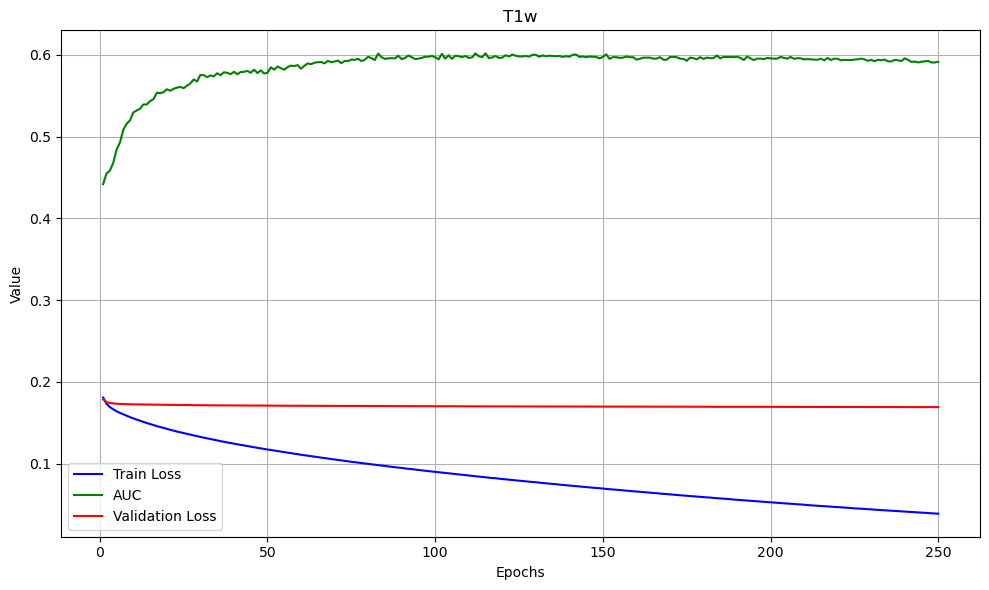

In [24]:
import matplotlib.pyplot as plt

# Example data (replace with your actual lists)
epochs = range(1, len(train_loss_list) + 1)

# Plotting all metrics on the same graph
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
plt.plot(epochs, auc_list, label='AUC', color='green')
plt.plot(epochs, val_loss_list, label='Validation Loss', color='red')
#plt.plot(epochs, val_acc_list, label='Validation Accuracy', color='orange')

plt.title('T1w')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
